# Hands-on 3 Tutorial: Técnica de Clasificación KMeans

- **Autor:** Angel Parada Pérez
- **Fecha** 8 de noviembre del 2025

## 1.1 Fundamentos de la técnica

K-Means es un algoritmo de clustering (agrupamiento) no supervisado que busca particionar iterativamente los datos en $K$ clusters. En cada paso, cada observación se asigna al centroide más cercano, con el objetivo de minimizar la suma de las distancias al cuadrado entre las muestras y el centroide del cluster al que pertenecen (inertia).

## 1.2 Modelo Matemático

Sea $$X = \{x_1, x_2, ..., x_n\} \subset \mathbb{R}^d$$ un conjunto de datos y $$\mu_1, \mu_2, ..., \mu_k$$ los centroides de los $k$ clústeres.  
El objetivo de K-Means es minimizar la suma de las distancias cuadradas dentro de cada clúster (*Within-Cluster Sum of Squares*, WCSS):

$$
J = \sum_{i=1}^{k} \sum_{x \in C_i} \|x - \mu_i\|^2
$$

donde:
* **$k$**: número de clústeres.
* **$C_i$**: conjunto de puntos asignados al clúster $i$.
* **$\mu_i$**: centroide del clúster $i$.

El algoritmo alterna entre dos pasos fundamentales:

1. **Asignación:** asignar cada punto $x$ al clúster cuyo centroide $\mu_i$ esté más cercano.  
2. **Actualización:** recalcular cada centroide $\mu_i$ como la media de los puntos pertenecientes a su clúster.

El proceso se repite hasta la convergencia, es decir, cuando las asignaciones ya no cambian o la variación de la función objetivo $J$ es mínima.


## 1.3 Descripción de la librería (breve)

Use `scikit-learn` (`sklearn`), que ofrece una implementación optimizada de KMeans en `sklearn.cluster.KMeans`.

**Clase principal:** `sklearn.cluster.KMeans` — parámetros relevantes:
- `n_clusters`: número de clusters K.
- `init`: inicialización de centroides ('k-means++' por defecto).
- `n_init`: número de inicializaciones independientes.
- `max_iter`: iteraciones por inicialización.
- `random_state`: semilla para reproducibilidad.

Tambien use
-`Pandas`: permite manipular los datos en forma de DataFrame y obtener estadísticas descriptivas del conjunto.

-`Matplotlib`: se usa para crear gráficos de dispersión (scatter plots) y visualizar los clusters y centroides del modelo.

-`Seaborn`: facilita la creación de gráficos estadísticos más atractivos, como mapas de calor (heatmaps) para mostrar la relación entre los clusters obtenidos y las etiquetas reales.

## 1.4 Pipeline

A continuación se muestran las etapas del pipeline con código ejecutable:

- Preprocesamiento
- Prediction (función que recibe un patrón y devuelve la clase predicha)
- Model Evaluation (matriz de confusión y accuracy)

Usare el dataset Iris como ejemplo práctico (incluye etiquetas verdaderas para poder evaluar la asignación de clusters).

## 1.4.1 Preprocesamiento


Estadísticas descriptivas:

                   count      mean       std  min  25%   50%  75%  max
sepal length (cm)  150.0  5.843333  0.828066  4.3  5.1  5.80  6.4  7.9
sepal width (cm)   150.0  3.057333  0.435866  2.0  2.8  3.00  3.3  4.4
petal length (cm)  150.0  3.758000  1.765298  1.0  1.6  4.35  5.1  6.9
petal width (cm)   150.0  1.199333  0.762238  0.1  0.3  1.30  1.8  2.5
target             150.0  1.000000  0.819232  0.0  0.0  1.00  2.0  2.0


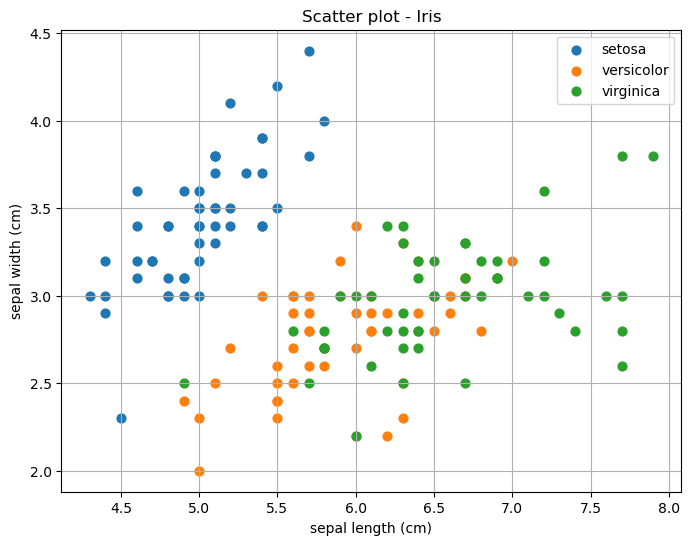

In [17]:

# Preprocesamiento: análisis estadístico y gráfico de dispersión
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.metrics import cluster as cluster_metrics
from sklearn.metrics import confusion_matrix, accuracy_score

# Cargar Iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

# Estadísticas descriptivas
desc = df.describe()
desc_transposed = desc.T
desc_transposed['std'] = df.std(numeric_only=True)  

# Mostrar estadísticas 
try:
    from caas_jupyter_tools import display_dataframe_to_user
    display_dataframe_to_user('Estadísticas descriptivas (Iris)', desc_transposed.reset_index())
except Exception:
    # fallback: imprimir
    print('\nEstadísticas descriptivas:\n')
    print(desc_transposed)



#Gráfico de dispersión (primeras dos dimensiones)
plt.figure(figsize=(8,6))
for lab in np.unique(y):
    mask = (y == lab)
    plt.scatter(X[mask,0], X[mask,1], label=iris.target_names[lab], s=40)
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.title('Scatter plot - Iris')
plt.legend()
plt.grid(True)
plt.show()


## 1.4.2 Entrenamiento del modelo KMeans

Inertia (suma de distancias al cuadrado dentro de clusters): 78.85144142614601
Centroides:
 [[5.9016129  2.7483871  4.39354839 1.43387097]
 [5.006      3.428      1.462      0.246     ]
 [6.85       3.07368421 5.74210526 2.07105263]]


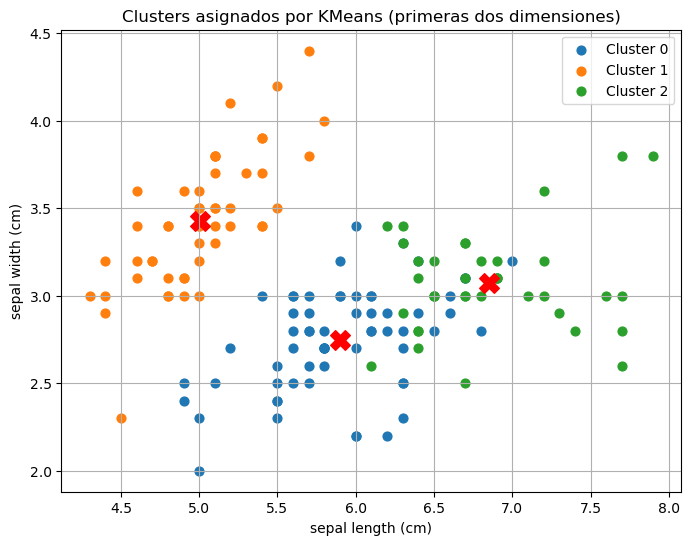

In [18]:

# Entrenamiento del modelo KMeans
k = 3
kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=42)
kmeans.fit(X)

print("Inertia (suma de distancias al cuadrado dentro de clusters):", kmeans.inertia_)
print("Centroides:\n", kmeans.cluster_centers_)

# Visualización: clusters asignados por el modelo
labels = kmeans.labels_
plt.figure(figsize=(8,6))
for lab in np.unique(labels):
    mask = (labels == lab)
    plt.scatter(X[mask,0], X[mask,1], s=40, label=f'Cluster {lab}')
# plot centroids
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='X', s=200, color='red')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.title('Clusters asignados por KMeans (primeras dos dimensiones)')
plt.legend()
plt.grid(True)
plt.show()



## 1.4.3 Prediction

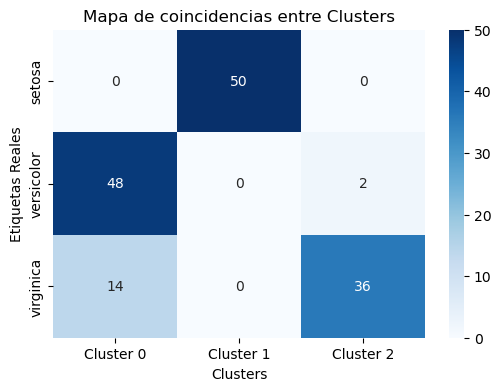

 Mapa de cluster -> etiqueta real (post-mapeo):
  Cluster 1 → setosa
  Cluster 0 → versicolor
  Cluster 2 → virginica


In [20]:

# Prediction: función que recibe un patrón (array-like) y retorna la clase predicha (mapeada a etiquetas reales)

# Mapear clusters a etiquetas reales (post-procesamiento)
try:
    from scipy.optimize import linear_sum_assignment
except Exception:
    linear_sum_assignment = None

def map_clusters_to_labels(true_labels, cluster_labels):
    """Crea un mapeo de clusters KMeans hacia etiquetas verdaderas, usando
    el método de asignación óptima (Hungarian algorithm)."""
    # matriz de contingencia (conteo entre etiquetas reales y clusters)
    cont = cluster_metrics.contingency_matrix(true_labels, cluster_labels)
    
    # Visualización de la matriz de contingencia
    plt.figure(figsize=(6,4))
    sns.heatmap(cont, annot=True, fmt="d", cmap="Blues",
                xticklabels=[f"Cluster {i}" for i in range(cont.shape[1])],
                yticklabels=iris.target_names)
    plt.title("Mapa de coincidencias entre Clusters")
    plt.xlabel("Clusters")
    plt.ylabel("Etiquetas Reales")
    plt.show()
    
    # buscar la mejor asignación (maximizar coincidencias)
    if linear_sum_assignment is not None:
        row_ind, col_ind = linear_sum_assignment(-cont)
        mapping = {c: r for r, c in zip(row_ind, col_ind)}
    else:
        # fallback
        mapping = {c: int(np.argmax(cont[:, c])) for c in range(cont.shape[1])}
    
    return mapping

# Crear mapeo y visualizacion
cluster_to_label = map_clusters_to_labels(y, labels)
print(" Mapa de cluster -> etiqueta real (post-mapeo):")
for c, l in cluster_to_label.items():
    print(f"  Cluster {c} → {iris.target_names[l]}")

# Función de predicción
def predict_pattern(pattern):
    """
    Recibe un patrón array-like (dim=4 para Iris)
    Retorna:
       - cluster asignado
       - etiqueta real mapeada (si existe)
    """
    arr = np.array(pattern).reshape(1, -1)
    cl = kmeans.predict(arr)[0]
    mapped = cluster_to_label.get(cl, None)
    return {
        'cluster': int(cl),
        'mapped_label': int(mapped) if mapped is not None else None,
        'mapped_label_name': iris.target_names[mapped] if mapped is not None else None
    }


## 1.4.4 Model Evaluation


Accuracy: 0.8933333333333333


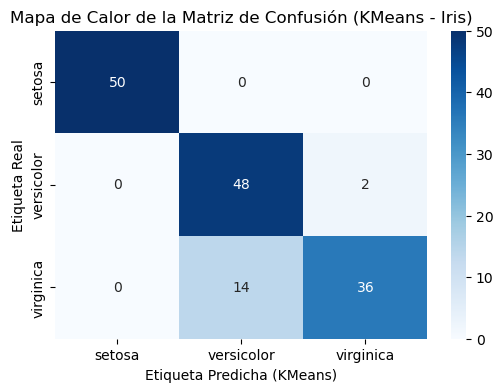


Interpretación breve:
- La matriz de confusión muestra cuántas muestras de cada clase real fueron asignadas a cada clase mapeada.
- El mapa de calor permite visualizar fácilmente los aciertos (diagonal principal) y los errores de clasificación.
- El valor de 'accuracy' indica la fracción de muestras correctamente asignadas después del mapeo de clusters a etiquetas reales.



In [21]:

# Evaluación del modelo: convertir predicciones de clusters a etiquetas mapeadas y evaluar

# obtener predicciones (clusters)
pred_clusters = kmeans.predict(X)

# mapear clusters a etiquetas
pred_mapped = [cluster_to_label[c] for c in pred_clusters]

# Matriz de confusión
cm = confusion_matrix(y, pred_mapped)
acc = accuracy_score(y, pred_mapped)

print("\nAccuracy:", acc)

# Obtener nombres reales de las clases
class_names = iris.target_names

# Visualización: mapa de calor con nombres
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Etiqueta Predicha (KMeans)")
plt.ylabel("Etiqueta Real")
plt.title("Mapa de Calor de la Matriz de Confusión (KMeans - Iris)")
plt.show()

# Breve explicación
print("\nInterpretación breve:") 
print("- La matriz de confusión muestra cuántas muestras de cada clase real fueron asignadas a cada clase mapeada.") 
print("- El mapa de calor permite visualizar fácilmente los aciertos (diagonal principal) y los errores de clasificación.") 
print("- El valor de 'accuracy' indica la fracción de muestras correctamente asignadas después del mapeo de clusters a etiquetas reales.\n")

## Referencias bibliográficas

- kmeans. (s/f). Unioviedo.es. Recuperado el 5 de noviembre de 2025, de https://www.unioviedo.es/compnum/laboratorios_py/kmeans/kmeans.html

- Na. (2018, marzo 12). K-Means con Python paso a paso. Aprendemachinelearning.com; Juan Ignacio Bagnato. https://www.aprendemachinelearning.com/k-means-en-python-paso-a-paso/

- Data Science with Onur [@onurdatascience]. (s/f). K-means clustering made easy: Step-by-step guide with scikit-learn python code [[Object Object]]. Youtube. Recuperado el 5 de noviembre de 2025, de https://www.youtube.com/watch?v=hBHoEbZohI0

- Kavlakoglu, E., & Winland, V. (2025, febrero 13). ¿Qué es la agrupación en clústeres k-means? Ibm.com. https://www.ibm.com/mx-es/think/topics/k-means-clustering
